(rv)=

# Radial Velocities


In this tutorial we will learn how to use `jaxoplanet` to compute the radial velocities of a star hosting a single exoplanet, and how to fit this dataset using `numpyro`.

```{note}
This tutorial requires some [extra packages](about.ipynb) that are not included in the `jaxoplanet` dependencies.
```

## Setup

We first setup the number of CPUs to use and enable the use of double-precision numbers with jax.

In [6]:
import jax
import numpyro

numpyro.set_host_device_count(2)
jax.config.update("jax_enable_x64", True)

## Model and dataset

Let's first generate our dataset, consisting in the radial velocities of a star orbited by a unique exoplanet. We start by defining the system (see for more details)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from jaxoplanet.orbits import keplerian

truth = dict(mass=0.02, period=3.0)
star = keplerian.Central(mass=1.0, radius=1.0)
system = keplerian.System(star).add_body(**truth)

As we left many parameters as default, let's check the parameters of the system

In [8]:
system

System(
  central=Central(mass=1.0, radius=1.0, density=0.238732414637843),
  _body_stack=ObjectStack(...)
)

We can now compute the radial velocities of the star and add some noise to simulate our dataset

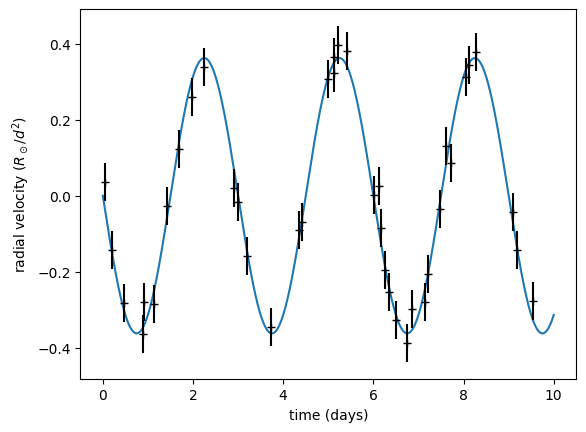

In [ ]:
np.random.seed(10)
over_time = np.linspace(0, 10, 1000)
over_rvs = system.radial_velocity(over_time)[0]
time = np.sort(np.random.uniform(0, 10, 40))
rv_obs = system.radial_velocity(time)[0]
rv_err = 0.05
rv_obs += rv_err * np.random.normal(size=len(time))


def plot_data():
    plt.errorbar(time, rv_obs, yerr=rv_err, fmt="+k")
    plt.xlabel("time (days)")
    plt.ylabel(r"radial velocity ($R_\odot/d$)")


plt.plot(over_time, over_rvs)
plot_data()

## Inference

We will infer the value and associated uncertainty of the system orbital parameters using `numpyro`. In order to do that we first define a callable `model` function

In [10]:
from numpyro import distributions as dist, infer


def rv_model(time, params):
    system = keplerian.System(star).add_body(
        mass=params["mass"], period=params["period"]
    )
    return system.radial_velocity(time)[0].magnitude


def model(time, y=None):
    mass = numpyro.sample("mass", dist.Uniform(0.01, 0.1))
    period = numpyro.sample("period", dist.Uniform(1.0, 10.0))
    error = numpyro.sample("error", dist.Uniform(0.01, 0.08))
    rv = rv_model(time, {"mass": mass, "period": period})

    # the likelihood function
    numpyro.sample("y", dist.Normal(rv, error), obs=y)

Once the model defined, we will sample the posterior likelihood of the model parameters given the observed radial velocities. As we will need to provide some initial values for these parameters, it is a good idea to check that these values provide a good starting point for the model.

In [11]:
init_values = {"mass": 0.022, "period": 3.01, "error": rv_err}
init_model = rv_model(over_time, init_values)

plt.plot(over_time, init_model, "C0")
plot_data()

AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute 'magnitude'

Starting from this initial guess, we use `numpyro`'s MCMC No-U-Turn Sampler (NUTS) to sample the posterior likelihood of the parameters.

In [ ]:
sampler = infer.MCMC(
    infer.NUTS(model, init_strategy=infer.init_to_value(values=init_values)),
    num_warmup=2000,
    num_samples=10000,
    progress_bar=True,
    num_chains=2,
)

sampler.run(jax.random.PRNGKey(6), time, y=rv_obs)

We can plot the inferred model with

In [ ]:
samples = sampler.get_samples()
posterior_rvs = infer.Predictive(model, samples)(jax.random.PRNGKey(0), over_time)["y"]

plot_data()
plt.plot(over_time, posterior_rvs.mean(0), "C0")
_ = plt.fill_between(
    over_time,
    *np.percentile(posterior_rvs, [16, 84], axis=0),
    alpha=0.3,
    color="C0",
)

and check the inferred model parameters in a corner plot

In [ ]:
import corner

_ = corner.corner(
    samples,
    var_names=["mass", "period"],
    truths=[truth["mass"], truth["period"]],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
)